# Importing the necessary files

In [1]:
import numpy as np
import pdb
import torch
from torch import nn  
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import datasets, models
from torch.utils.data import Dataset
from copy import deepcopy
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt
import tensorflow as tf
from scipy import stats
import time
from sklearn.metrics import pairwise_distances
%matplotlib inline

In [2]:
from google.colab import files
files.upload()

Saving resnet.py to resnet (15).py


{'resnet.py': b"#!/usr/bin/env python\n# coding: utf-8\n\n# In[ ]:\n\n\n'''ResNet in PyTorch.\nFor Pre-activation ResNet, see 'preact_resnet.py'.\nReference:\n[1] Kaiming He, Xiangyu Zhang, Shaoqing Ren, Jian Sun\n    Deep Residual Learning for Image Recognition. arXiv:1512.03385\n'''\nimport torch\nimport torch.nn as nn\nimport torch.nn.functional as F\nimport pdb\nfrom torch.autograd import Variable\n\n\nclass BasicBlock(nn.Module):\n    expansion = 1\n\n    def __init__(self, in_planes, planes, stride=1):\n        super(BasicBlock, self).__init__()\n        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)\n        self.bn1 = nn.BatchNorm2d(planes)\n        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)\n        self.bn2 = nn.BatchNorm2d(planes)\n\n        self.shortcut = nn.Sequential()\n        if stride != 1 or in_planes != self.expansion*planes:\n            self.shortcut = nn.Sequential(\n     

In [3]:
import resnet

# Obtaining the dataset

In [4]:
def get_dataset(name, path):
    if name == 'CIFAR10':
        return get_CIFAR10(path)

def get_CIFAR10(path):
    data_tr = datasets.CIFAR10('data', train=True, download=True)
    data_te = datasets.CIFAR10('data', train=False, download=True)
    X_tr = data_tr.data
    Y_tr = torch.from_numpy(np.array(data_tr.targets))
    X_te = data_te.data
    Y_te = torch.from_numpy(np.array(data_te.targets))
    return X_tr, Y_tr, X_te, Y_te

# Transforming the data

In [5]:
def get_handler(name):
    if name == 'CIFAR10':
        return DataHandler

class DataHandler(Dataset):
    def __init__(self, X, Y, transform=None):
        self.X = X
        self.Y = Y
        self.transform = transform

    def __getitem__(self, index):
        x, y = self.X[index], self.Y[index]
        if self.transform is not None:
            x = Image.fromarray(x)
            x = self.transform(x)
        return x, y, index

    def __len__(self):
        return len(self.X)

# Loading the data

In [6]:
X_tr, Y_tr, X_te, Y_te = get_dataset('CIFAR10','data')
train_data_reshape = np.shape(X_tr)[1:]
handler = get_handler('CIFAR10')

Files already downloaded and verified
Files already downloaded and verified


# CIFAR10 Data Defaults

In [7]:
args_pool = {'CIFAR10':
                {'n_epoch': 3, 
    'transform': transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470,     0.2435, 0.2616))]),
    'loader_tr_args':{'batch_size': 128, 'num_workers': 3},
    'loader_te_args':{'batch_size': 1000, 'num_workers': 1},
    'optimizer_args':{'lr': 0.05, 'momentum': 0.3},
    'transformTest': transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))])}    
}

args = args_pool['CIFAR10']
args['lr'] = 1e-4

handler = get_handler('CIFAR10')

# Initializing labeled  and unlabelled pools

In [8]:
n_pool = len(Y_tr)
n_test = len(Y_te)
NUM_INIT_LB = 10000
print('number of labeled pool: {}'.format(NUM_INIT_LB), flush=True)
print('number of unlabeled pool: {}'.format(n_pool - NUM_INIT_LB), flush=True)
print('number of testing pool: {}'.format(n_test), flush=True)

idxs_lb = np.zeros(n_pool, dtype=bool)
idxs_tmp = np.arange(n_pool)
np.random.shuffle(idxs_tmp)
idxs_lb[idxs_tmp[:NUM_INIT_LB]] = True

number of labeled pool: 10000
number of unlabeled pool: 40000
number of testing pool: 10000


In [9]:
# idxs_lb[:50]

# Loading in the pre-trained classifier (RESNET18)

In [10]:
net = resnet.ResNet18()

In [11]:
# net

# Getting the embeddings

In [12]:
class Embedding_Strategy:
    def __init__(self, X, Y, idxs_lb, net, handler, args):
        self.X = X
        self.Y = Y
        self.idxs_lb = idxs_lb
        self.net = net
        self.handler = handler
        self.args = args
        self.n_pool = len(Y)
        use_cuda = torch.cuda.is_available()

    def query(self, n):
        pass

    def update(self, idxs_lb):
        self.idxs_lb = idxs_lb

    def _train(self, epoch, loader_tr, optimizer):
        self.clf.train()
        accFinal = 0.
        for batch_idx, (x, y, idxs) in enumerate(loader_tr):
            x, y = Variable(x.cuda()), Variable(y.cuda())
            optimizer.zero_grad()
            out, e1 = self.clf(x)
            loss = F.cross_entropy(out, y)
            accFinal += torch.sum((torch.max(out,1)[1] == y).float()).data.item()
            loss.backward()

            # clamp gradients, just in case
            for p in filter(lambda p: p.grad is not None, self.clf.parameters()): p.grad.data.clamp_(min=-.1, max=.1)

            optimizer.step()
        return accFinal / len(loader_tr.dataset.X)


    
    def train(self):
        def weight_reset(m):
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                m.reset_parameters()

        n_epoch = self.args['n_epoch']
        self.clf =  self.net.apply(weight_reset).cuda()
        optimizer = optim.Adam(self.clf.parameters(), lr = self.args['lr'], weight_decay=0)

        idxs_train = np.arange(self.n_pool)[self.idxs_lb]
        loader_tr = DataLoader(self.handler(self.X[idxs_train], torch.Tensor(self.Y.numpy()[idxs_train]).long(), transform=self.args['transform']), shuffle=True, **self.args['loader_tr_args'])
   
        epoch = 1
        accCurrent = 0.
        while accCurrent < 0.99: 
            accCurrent = self._train(epoch, loader_tr, optimizer)
            epoch += 1
            print(str(epoch) + ' training accuracy: ' + str(accCurrent), flush=True)
            if (epoch % 50 == 0) and (accCurrent < 0.2): # reset if not converging
                self.clf = self.net.apply(weight_reset)
                optimizer = optim.Adam(self.clf.parameters(), lr = self.args['lr'], weight_decay=0)

    def predict(self, X, Y):
        def weight_reset(m):
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                m.reset_parameters()

        if type(X) is np.ndarray:
            loader_te = DataLoader(self.handler(X, Y, transform=self.args['transformTest']),
                            shuffle=False, **self.args['loader_te_args'])
        else: 
            loader_te = DataLoader(self.handler(X.numpy(), Y, transform=self.args['transformTest']),
                            shuffle=False, **self.args['loader_te_args'])
            
        self.clf =  self.net.apply(weight_reset).cuda()
        self.clf.eval()
        P = torch.zeros(len(Y)).long()
        with torch.no_grad():
            for x, y, idxs in loader_te:
                x, y = Variable(x.cuda()), Variable(y.cuda())
                out, e1 = self.clf(x)
                pred = out.max(1)[1]
                P[idxs] = pred.data.cpu()
        return P

    def predict_prob(self, X, Y):
        def weight_reset(m):
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                m.reset_parameters()

        loader_te = DataLoader(self.handler(X, Y, transform=self.args['transformTest']), shuffle=False, **self.args['loader_te_args'])
        self.clf =  self.net.apply(weight_reset).cuda()
        self.clf.eval()
        probs = torch.zeros([len(Y), len(np.unique(self.Y))])
        with torch.no_grad():
            for x, y, idxs in loader_te:
                x, y = Variable(x.cuda()), Variable(y.cuda())
                out, e1 = self.clf(x)
                prob = F.softmax(out, dim=1)
                probs[idxs] = prob.cpu().data
        
        return probs

    def get_embedding(self, X, Y):
        def weight_reset(m):
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                m.reset_parameters()

        loader_te = DataLoader(self.handler(X, Y, transform=self.args['transformTest']),
                            shuffle=False, **self.args['loader_te_args'])
        self.clf =  self.net.apply(weight_reset).cuda()
        self.clf.eval()
        embedding = torch.zeros([len(Y), self.clf.get_embedding_dim()])
        with torch.no_grad():
            for x, y, idxs in loader_te:
                x, y = Variable(x.cuda()), Variable(y.cuda())
                out, e1 = self.clf(x)
                embedding[idxs] = e1.data.cpu()
        
        return embedding

    def get_grad_embedding(self, X, Y):
        def weight_reset(m):
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                m.reset_parameters()

        # self.clf =  self.net.apply(weight_reset).cuda()
        model = self.net.apply(weight_reset).cuda()
        embDim = model.get_embedding_dim()
        model.eval()
        nLab = len(np.unique(Y))
        embedding = np.zeros([len(Y), embDim * nLab])
        loader_te = DataLoader(self.handler(X, Y, transform=self.args['transformTest']),
                            shuffle=False, **self.args['loader_te_args'])
        with torch.no_grad():
            for x, y, idxs in loader_te:
                x, y = Variable(x.cuda()), Variable(y.cuda())
                cout, out = self.clf(x)
                out = out.data.cpu().numpy()
                batchProbs = F.softmax(cout, dim=1).data.cpu().numpy()
                maxInds = np.argmax(batchProbs,1)
                for j in range(len(y)):
                    for c in range(nLab):
                        if c == maxInds[j]:
                            embedding[idxs[j]][embDim * c : embDim * (c+1)] = deepcopy(out[j]) * (1 - batchProbs[j][c])
                        else:
                            embedding[idxs[j]][embDim * c : embDim * (c+1)] = deepcopy(out[j]) * (-1 * batchProbs[j][c])
            return torch.Tensor(embedding)

# Embeddings of the set of examples not used for training 

In [13]:
nStart = 100        # number of points to start with
nEnd = 10000        # total number of points to query
nQuery = 100        # number of points to query in a batch

NUM_ROUND = int((nEnd - nStart)/ nQuery)

T = Embedding_Strategy(X = X_tr, Y = Y_tr, idxs_lb = idxs_lb, net = net, handler = handler, args = args)
T.train()
P = Embedding_Strategy(X = X_tr, Y = Y_tr, idxs_lb = idxs_lb, net = net, handler = handler, args = args)
P = P.predict(X = X_te, Y= Y_te)
acc = np.zeros(NUM_ROUND+1)
acc[0] = 10.0 * (Y_te == P).sum().item() / len(Y_te)
print(str(nStart) + '\ttesting accuracy {}'.format(acc[0]), flush=True)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


2 training accuracy: 0.2698
3 training accuracy: 0.4065
4 training accuracy: 0.4819
5 training accuracy: 0.555
6 training accuracy: 0.6353
7 training accuracy: 0.7097
8 training accuracy: 0.7943
9 training accuracy: 0.8635
10 training accuracy: 0.9129
11 training accuracy: 0.9531
12 training accuracy: 0.9713
13 training accuracy: 0.9799
14 training accuracy: 0.9847
15 training accuracy: 0.9941
100	testing accuracy 1.0


In [14]:
E = Embedding_Strategy(X = X_tr, Y = Y_tr, idxs_lb = idxs_lb, net = net, handler = handler, args = args)
E = E.get_embedding(X = X_te, Y = Y_te)

In [15]:
E # THE EMBEDDINGS OF EXAMPLES NOT USED FOR TRAINNIG

tensor([[ 4.8170,  6.1824,  5.5257,  ..., 20.8166, 18.5582, 15.6959],
        [ 6.5492,  8.1064,  6.7557,  ..., 28.4398, 24.9890, 22.0403],
        [ 6.3973,  6.4057,  4.4989,  ..., 22.1832, 18.7391, 16.6849],
        ...,
        [11.7129, 10.2799,  9.3658,  ..., 38.6892, 31.5401, 33.0650],
        [ 5.8590,  5.4022,  6.4838,  ..., 24.9172, 23.0102, 19.3911],
        [ 5.3949,  5.4691,  6.2789,  ..., 20.8778, 18.6600, 16.9809]])

In [16]:
if type(E[0]) is not np.ndarray:
    E = E.numpy()

In [17]:
V = E.astype(int)  # converting from float to int

# Getting the norms of the embeddings

In [18]:
emb_norms = []
for i in V:
    emb_norms.append(np.linalg.norm(i)/10)

In [19]:
# emb_norms[0:5]

# Obtaining the probability mass of each embedding

In [20]:
Prob = Embedding_Strategy(X = X_tr, Y = Y_tr, idxs_lb = idxs_lb, net = net, handler = handler, args = args)
Prob = Prob.predict_prob(X = X_te, Y = Y_te)

In [21]:
prob_norms = []
for i in Prob:
    prob_norms.append(np.linalg.norm(i))

In [22]:
 # prob_norms[0:5]

# Sorting the embeddings

In [23]:
prob_norms = np.array(prob_norms)

inds = prob_norms.argsort()

In [24]:
# inds

In [25]:
emb_norms = np.array(emb_norms)

sorted_emb_norms = emb_norms[inds]

In [26]:
# sorted_emb_norms

In [27]:
sorted_prob_norms = prob_norms[inds]

In [28]:
# sorted_prob_norms

# Plot of smallest 1000 magnitude examples based on probability mass

Text(0, 0.5, 'Probability mass on hypothetical labels')

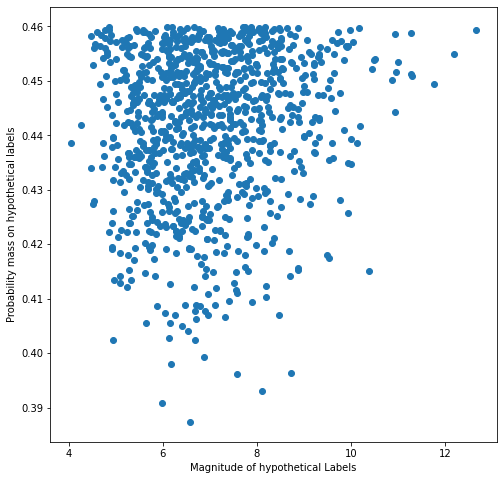

In [29]:
plt.figure(figsize=(8,8))
plt.scatter(sorted_emb_norms[:1000], sorted_prob_norms[:1000])
plt.xlabel('Magnitude of hypothetical Labels')
plt.ylabel('Probability mass on hypothetical labels')

# Plot of the largest 1000 magnitude examples based on probability mass

Text(0, 0.5, 'Probability mass on hypothetical labels')

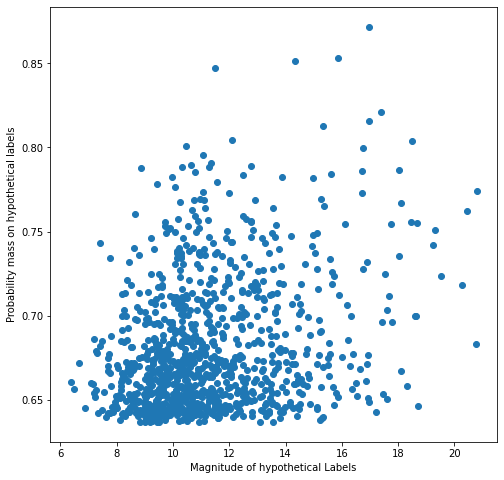

In [30]:
plt.figure(figsize=(8,8))
plt.scatter(sorted_emb_norms[-1000:], sorted_prob_norms[-1000:])
plt.xlabel('Magnitude of hypothetical Labels')
plt.ylabel('Probability mass on hypothetical labels')

# K-Means++ Algorithm 

In [31]:
# kmeans ++ initialization
def init_centers(X, K):
    ind = np.argmax([np.linalg.norm(s, 2) for s in X])
    mu = [X[ind]]
    indsAll = [ind]
    centInds = [0.] * len(X)
    cent = 0
    #print('#Samps\tTotal Distance')
    while len(mu) < K:
        if len(mu) == 1:
            D2 = pairwise_distances(X, mu).ravel().astype(float)
        else:
            newD = pairwise_distances(X, [mu[-1]]).ravel().astype(float)
            for i in range(len(X)):
                if D2[i] >  newD[i]:
                    centInds[i] = cent
                    D2[i] = newD[i]
        #print(str(len(mu)) + '\t' + str(sum(D2)), flush=True)
        if sum(D2) == 0.0: pdb.set_trace()
        D2 = D2.ravel().astype(float)
        Ddist = (D2 ** 2)/ sum(D2 ** 2)
        customDist = stats.rv_discrete(name='custm', values=(np.arange(len(D2)), Ddist))
        ind = customDist.rvs(size=1)[0]
        while ind in indsAll: ind = customDist.rvs(size=1)[0]
        mu.append(X[ind])
        indsAll.append(ind)
        cent += 1
    return indsAll

class BadgeSampling(Embedding_Strategy):
    def __init__(self, X, Y, idxs_lb, net, handler, args):
        super(BadgeSampling, self).__init__(X, Y, idxs_lb, net, handler, args)

    def query(self, n):
        def weight_reset(m):
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                m.reset_parameters()

        self.clf =  self.net.apply(weight_reset).cuda() 

        idxs_unlabeled = np.arange(self.n_pool)[~self.idxs_lb]
        gradEmbedding = self.get_grad_embedding(self.X[idxs_unlabeled], self.Y.numpy()[idxs_unlabeled]).numpy()
        chosen = init_centers(gradEmbedding, n),
        return idxs_unlabeled[chosen]/10

# Selecting candidates with K-Means++

In [32]:
Chosen = BadgeSampling(X = X_tr, Y = Y_tr, idxs_lb = idxs_lb, net = net, handler = handler, args = args)
Chosen = Chosen.query(nQuery).astype(int)

In [33]:
# Chosen

# Visualizing the selected candidates

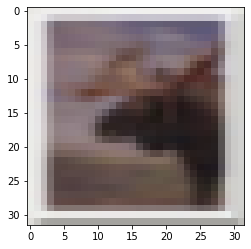

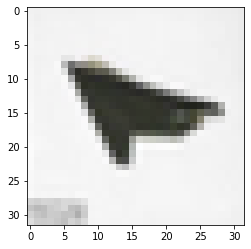

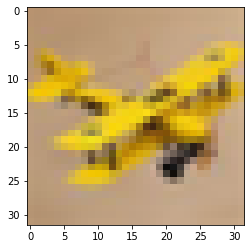

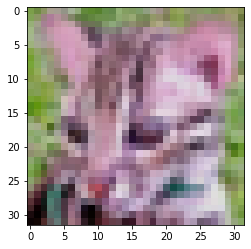

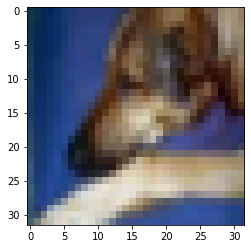

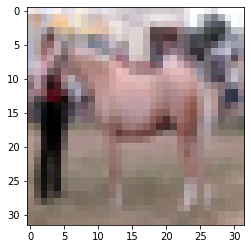

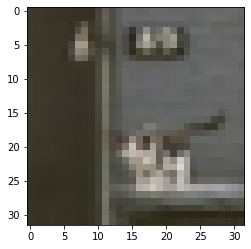

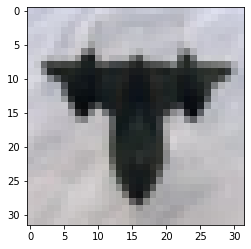

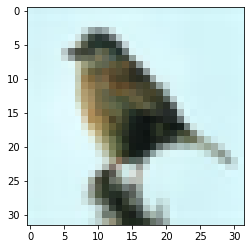

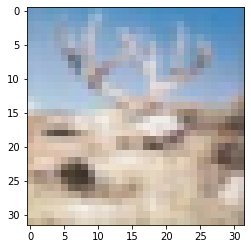

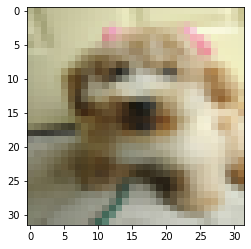

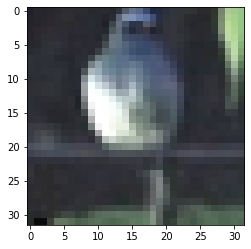

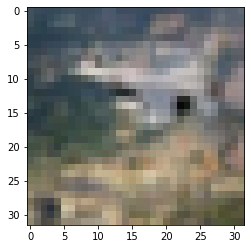

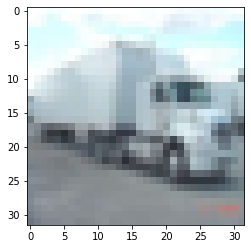

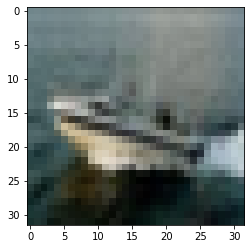

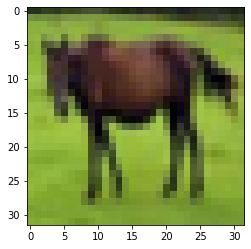

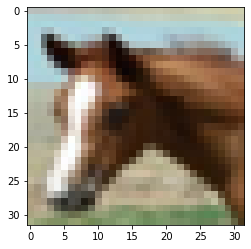

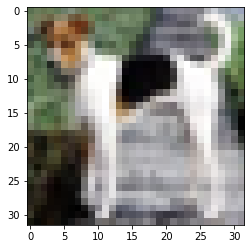

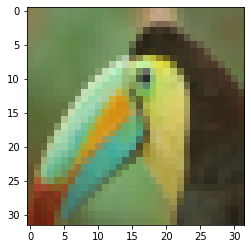

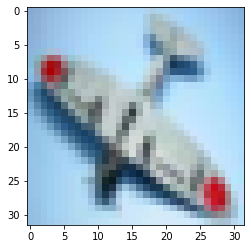

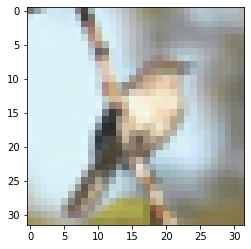

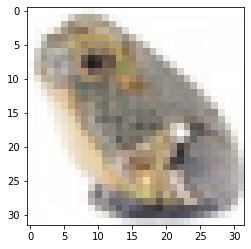

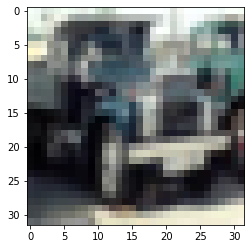

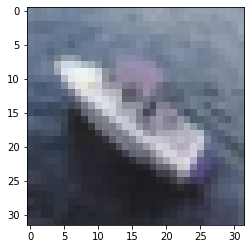

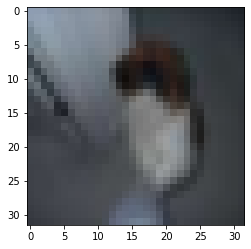

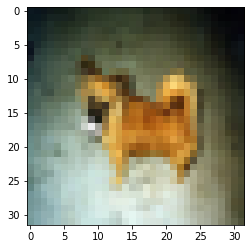

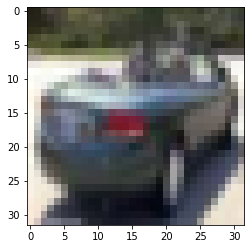

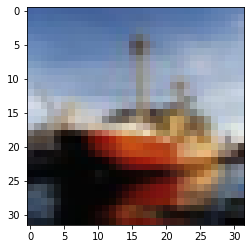

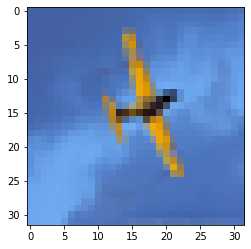

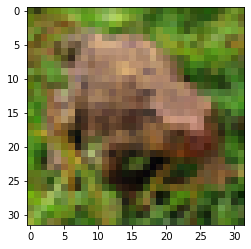

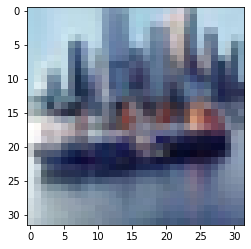

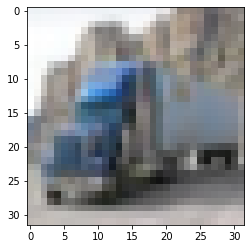

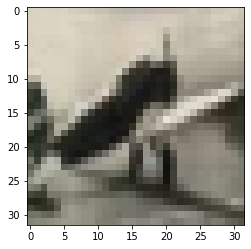

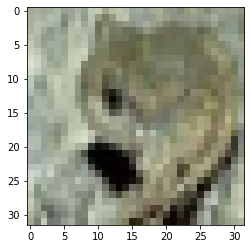

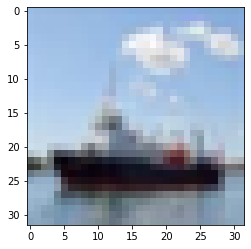

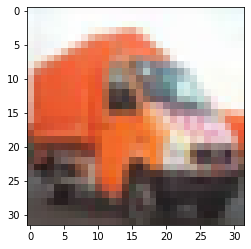

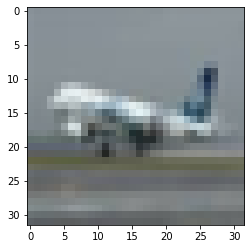

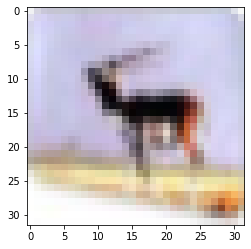

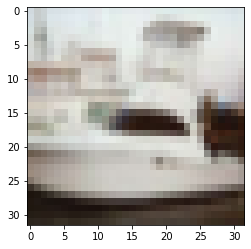

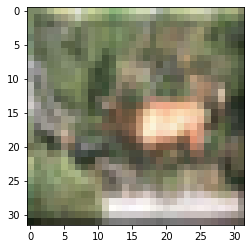

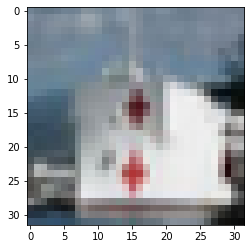

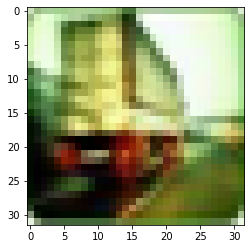

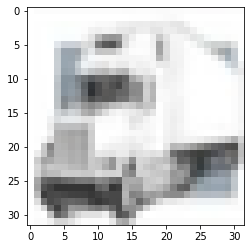

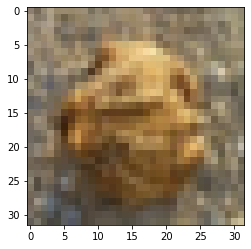

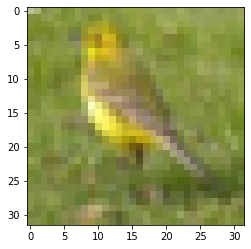

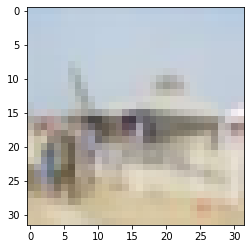

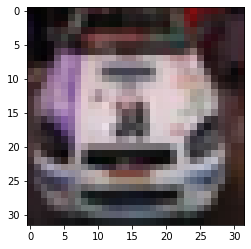

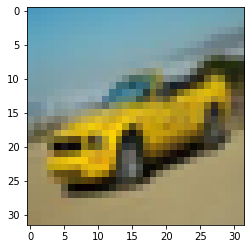

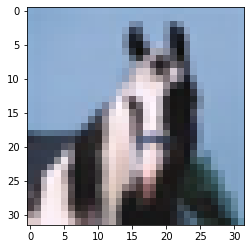

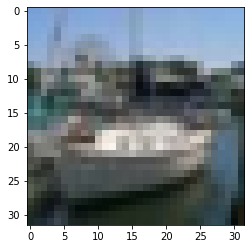

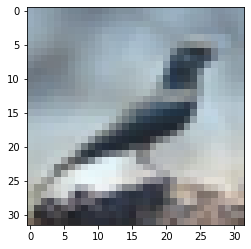

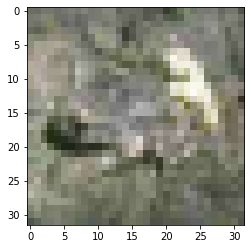

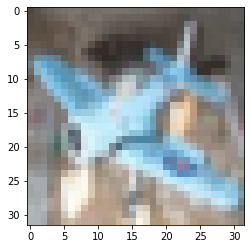

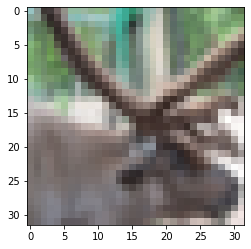

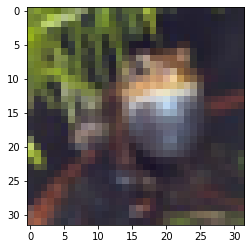

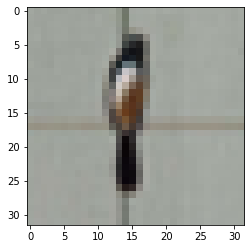

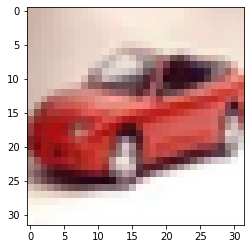

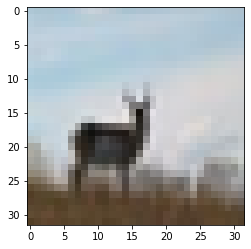

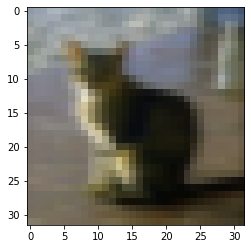

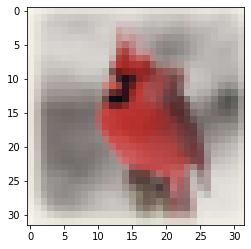

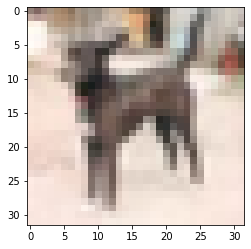

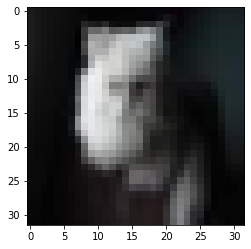

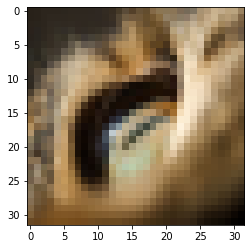

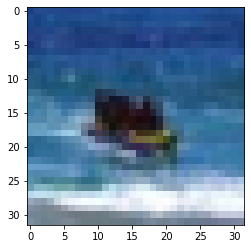

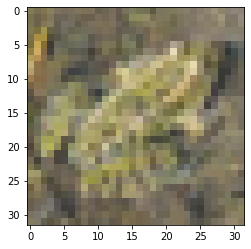

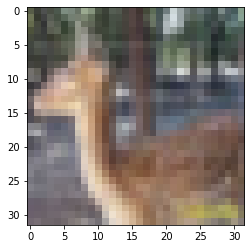

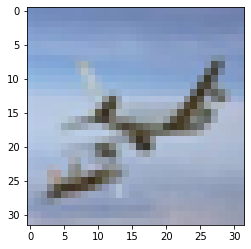

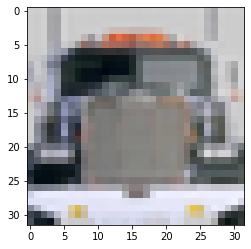

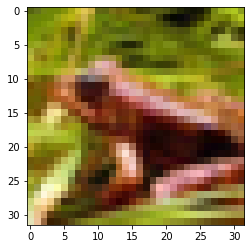

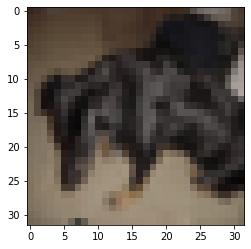

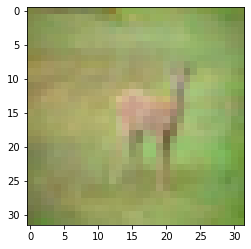

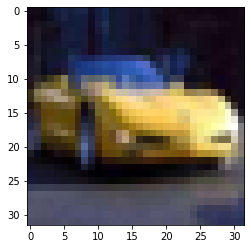

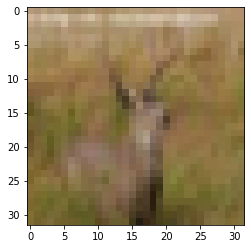

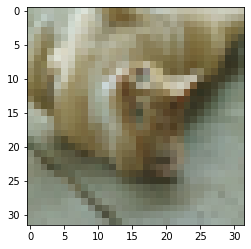

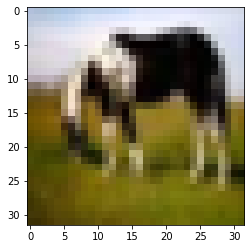

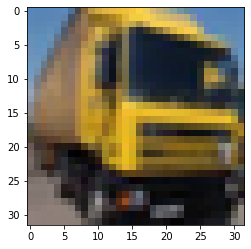

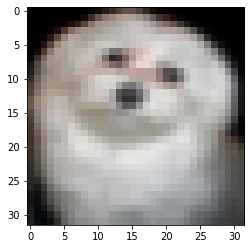

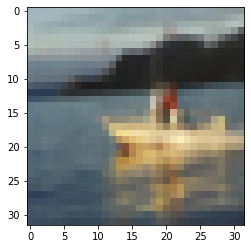

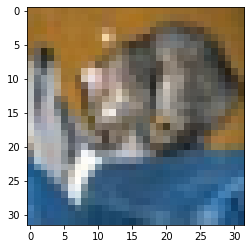

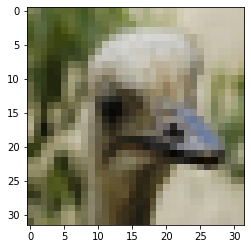

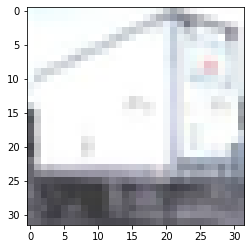

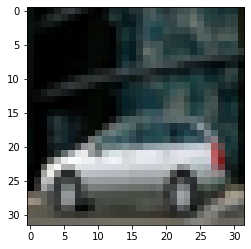

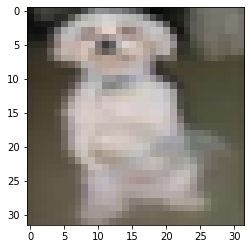

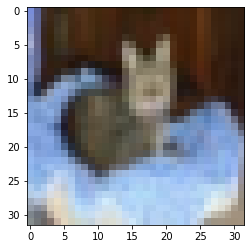

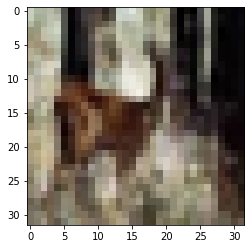

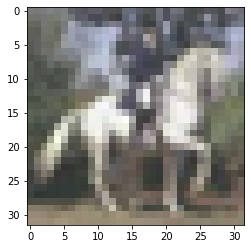

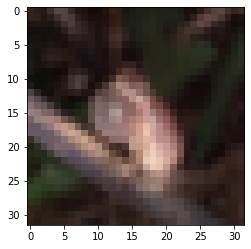

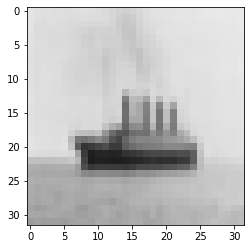

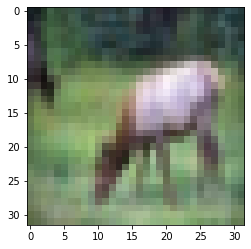

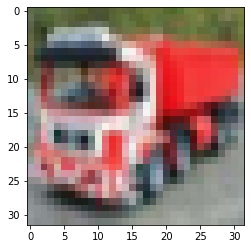

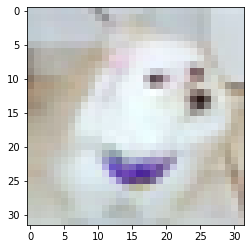

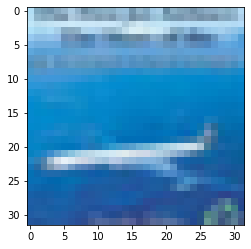

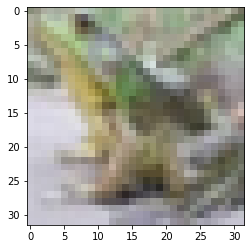

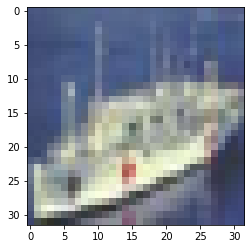

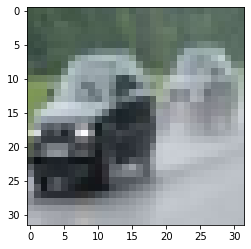

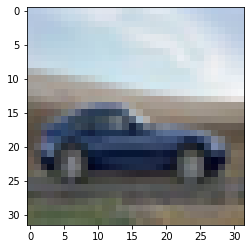

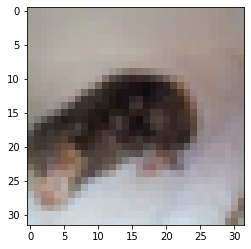

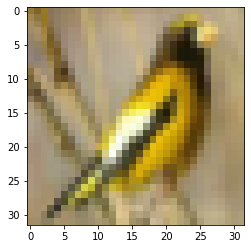

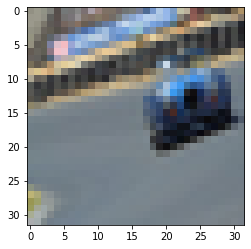

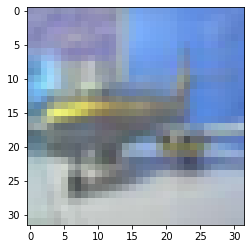

In [33]:
for x in Chosen:
  plt.imshow(X_te[x])
  plt.show()